In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  7 22:16:28 2023

@author: hzhang
"""

import os
import math
import sys
import copy
import scipy
import pickle
import matplotlib.lines as mlines
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import spsolve
from numpy.linalg import norm
from numpy.linalg import qr
from  scipy.linalg import  svdvals
import jax.numpy as jnp
import numpy as np
import jax.random as random
from jax import pmap
from jax import vmap
from jax import jit
import jax.ops
import time
from jax import config
jax.config.update("jax_enable_x64", True)
from jax.scipy.special import logsumexp
import pathlib
from tempfile import TemporaryFile
import matplotlib.pyplot as plt

import pylab as pl
from IPython import display
#%%
@jit 
def logansatz(s,fftW0,b0):
    Fsigma=jnp.fft.fft(2*s-1)
    theta=jnp.fft.ifft(fftW0*jnp.conj(Fsigma))+b0
    logx_sigma=jnp.sum(jnp.log(jnp.cosh(theta)))
#     x_sigma=jnp.exp(logx_sigma)
    return logx_sigma
logansatz1 = vmap(logansatz, (0, None, None), 0)
jlogansatz= jit(logansatz1)
logansatz2 = vmap(jlogansatz, (0, 0, 0), 0)
jjlogansatz = jit(logansatz2)

@jit
def compute(s,fftW0,b0):
    Fsigma=jnp.fft.fft(2*s-1)
    theta=jnp.fft.ifft(fftW0*jnp.conj(Fsigma))+b0
    logx_sigma=jnp.sum(jnp.log(jnp.cosh(theta)))
    tanhtheta=jnp.tanh(theta)
    dlogx_sigma_db=jnp.sum(tanhtheta,axis=-1)
    dlogx_sigma_dw=jnp.fft.ifft(jnp.fft.fft(tanhtheta)*Fsigma)
    dlogx_dweights=jnp.concatenate((dlogx_sigma_dw.flatten(),jnp.reshape(dlogx_sigma_db,(-1,))))
    return logx_sigma, dlogx_dweights
compute1 = vmap(compute, (0, None, None), 0)
jcompute = jit(compute1)
compute2 = vmap(jcompute, (None, 0, 0), 0)
jjcompute = jit(compute2)
compute3 = vmap(jjcompute, (0, None, None), 0)
jjjcompute = jit(compute3)

compute_respective = vmap(jcompute, (0, 0,0), 0)
jcompute_respective = jit(compute_respective)

@jit
def queryHx_x_more(state, fftW0, b0,logxstate,dlogxstate_dweights):
    sames= state ^ state[(jnp.arange(d) + 1) % d]
    energy1 = 2*jnp.sum(sames)-d
    Hx1_x = -delta*energy1
    Hdx1_x= -delta*energy1*dlogxstate_dweights
     
    statesxy = jnp.repeat(jnp.expand_dims(state, -1), d, -1).T
    i0 = jnp.arange(d)
    
    statesxy = statesxy.at[i0,i0].set(~statesxy[i0,  i0])
    statesxy = statesxy.at[i0, (i0+1)%d].set(~statesxy[i0, (i0+1)%d])

    logxstatesxy,dlogxstatesxy=jcompute(statesxy, fftW0, b0)
    wave_ratios=jnp.exp(logxstatesxy-logxstate)
    sameswave_ratios=sames*wave_ratios
    Hx2_x = -2*jnp.sum(sameswave_ratios)    
    Hdx2_x= -2*jnp.sum(dlogxstatesxy*sameswave_ratios.reshape(-1,1),axis=0) 
    return Hx1_x+Hx2_x,Hdx1_x+Hdx2_x

queryHx_x_more1 = vmap(queryHx_x_more, (0, None, None,0,0), 0)
jqueryHx_x_more = jit(queryHx_x_more1)
queryHx_x_more2 = vmap(jqueryHx_x_more, (None, 0, 0,0,0), 0)
jjqueryHx_x_more = jit(queryHx_x_more2)

@jit
def queryHx_x(state, fftW0, b0,logxstate):
    sames= state ^ state[(jnp.arange(d) + 1) % d]
    energy1 = 2*jnp.sum(sames)-d
    Hx1_x = -delta*energy1
     
    statesxy = jnp.repeat(jnp.expand_dims(state, -1), d, -1).T
    i0 = jnp.arange(d)
    
    statesxy = statesxy.at[i0,i0].set(~statesxy[i0,  i0])
    statesxy = statesxy.at[i0, (i0+1)%d].set(~statesxy[i0, (i0+1)%d])

    logxstatesxy,dlogxstatesxy=jcompute(statesxy, fftW0, b0)
    wave_ratios=jnp.exp(logxstatesxy-logxstate)
    sameswave_ratios=sames*wave_ratios
    Hx2_x = -2*jnp.sum(sameswave_ratios)    
    return Hx1_x+Hx2_x

queryHx_x1 = vmap(queryHx_x, (0, None, None,0), 0)
jqueryHx_x = jit(queryHx_x1)
queryHx_x2 = vmap(jqueryHx_x, (None, 0, 0,0), 0)
jjqueryHx_x = jit(queryHx_x2)

queryHx_x_respective = vmap(jqueryHx_x, (0, 0, 0,0), 0)
jjqueryHx_x_respective = jit(queryHx_x_respective) 
 

def compute_ground_excited_Hloc(v,fftW0,b0,states):
    logstates, dlogstates=jjcompute(states,fftW0,b0)
    Hloc=jjqueryHx_x(states, fftW0, b0,logstates)
    vg=v[:,0][...,None]
    ve=v[:,1][...,None]
    logphig=logsumexp(logstates, b=vg,axis=0)
    logphie=logsumexp(logstates, b=ve,axis=0)
    coef_g= np.exp(np.log(vg)+logstates-logphig)
    coef_e= np.exp(np.log(ve)+logstates-logphie)
    Hloc_g=(coef_g*Hloc).sum(axis=0)
    Hloc_e=(coef_e*Hloc).sum(axis=0)
    return Hloc_g, Hloc_e
    
@jit
def cvcompute(state):
    sames= state ^ state[(jnp.arange(d) + 1) % d]
    energy1 = 2*jnp.sum(sames)-d
    return -energy1/d
cvcompute1 = vmap(cvcompute, 0, 0)
jcvcompute= jit(cvcompute1) 
cvcompute2 = vmap(jcvcompute, 0, 0)
jjcvcompute = jit(cvcompute2)

@jit
#with Eloc_i, used for RGN
def sample_more(inputs,i):
    inputs,store_flipornot=jax.lax.scan(update,inputs,None,d)
    paccflip=jnp.mean(store_flipornot, axis=0)
    key,states,cvstates,fftW0,b0=inputs
    logxstates, dlogx_dweights=jcompute(states,fftW0,b0)
    Hxstates=jqueryHx_x(states,fftW0,b0,logxstates)
    cvstates=jcvcompute(states)
    return (key,states,cvstates,fftW0,b0),(states,logxstates, dlogx_dweights, Hxstates,cvstates)
@jit
def update(inputs,i):
    key,states,cvstates,fftW0,b0=inputs
    key, key1,key2 = random.split(key, num=3)
    i0=jnp.arange(parallel)
    perturbs=states
    i1 = random.choice(key1,d ,shape=(parallel,))
    perturbs = perturbs.at[i0, i1].set(~perturbs[i0, i1])
    logxperturbs=jlogansatz(perturbs,fftW0,b0)
    logxstates=jlogansatz(states,fftW0,b0)
    flipornot=random.exponential(key,(parallel,))
    flipornot=(-0.5*flipornot<logxperturbs.real-logxstates.real)
    states=jax.numpy.where(jnp.reshape(flipornot, (-1,1)),perturbs,states)
    return (key,states,cvstates,fftW0,b0),flipornot

@jit
def update_both(inputs,i):
    key,states,cvstates,fftW0,b0=inputs
    key, key1,key2 = random.split(key, num=3)
    i0=jnp.repeat(np.arange(M),parallel)
    i1=jnp.tile(np.arange(parallel),M)
    i2 = random.choice(key1,d ,shape=(M*parallel,))
    perturbs=states
    perturbs = perturbs.at[i0, i1, i2].set(~perturbs[i0, i1, i2])
    
    logxperturbs=jjlogansatz(perturbs,fftW0,b0)
    logxstates=jjlogansatz(states,fftW0,b0)
    flipornot=random.exponential(key,(M,parallel,))
    flipornot=(-0.5*flipornot<logxperturbs.real-logxstates.real)
    states=jax.numpy.where(flipornot[...,None],perturbs,states)
    return (key,states,cvstates,fftW0,b0),flipornot
@jit
#with Eloc_i, used for RGN
def sample_both(inputs,i):
    inputs,store_flipornot=jax.lax.scan(update_both,inputs,None,d)
    paccflip=jnp.mean(store_flipornot, axis=0)
    key,states,cvstates,fftW0,b0=inputs
    logxstates, dlogx_dweights=jcompute_respective(states,fftW0,b0)
    Hxstates=jjqueryHx_x_respective(states,fftW0,b0,logxstates)
    cvstates=jjcvcompute(states)
    return (key,states,cvstates,fftW0,b0),(states,logxstates, dlogx_dweights, Hxstates,cvstates)


def compute_covariance(beta, samples_a_dist1, samples_a_dist2,samples_b_dist1 ,samples_b_dist2,amean, bmean):
    # Given beta, samples of a(x) with distribution1, 2 , samples of b(x) with distribution1, 2,
    # Given E_{(1-beta)*dist1+beta*dist2}[a] and E_{(1-beta)*dist1+beta*dist2}[b] 
    # Compute Cov_{(1-beta)*dist1+beta*dist2}(a.conj(),b). (Cov here doesn't include complex conjugate)
    # which can be computed as E_{(1-beta)*dist1+beta*dist2}[ (a-amean).conj()*(b-bmean)]=
    # (1-beta)E_{ dist1}[ (a-amean).conj()*(b-bmean)]+beta*E_{ dist2}[ (a-amean).conj()*(b-bmean)]
    prod_dist1= (samples_a_dist1-amean).conj()*(samples_b_dist1-bmean)
    prod_dist2= (samples_a_dist2-amean).conj()*(samples_b_dist2-bmean)
    return (1-beta)*prod_dist1.mean(axis=0)+beta *prod_dist2.mean(axis=0)

    # the prod_dist1 should correspond to (1-beta) weight and prod_dist2 should correspond to beta weight. 

import importlib
import EMUS_func_utils #import the module here, so that it can be reloaded.
importlib.reload(EMUS_func_utils)
from EMUS_func_utils import * # or whatever name you want.
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['savefig.dpi'] = 300
import itertools
def plotcvlogHloc(ax0,ax1,fftW0,b0):    
    logmix, dlogmix=jcompute(mixedsamples,fftW0,b0)
    cvmix=jcvcompute(mixedsamples)
    Hlocmix=jqueryHx_x(mixedsamples, fftW0, b0,logmix,delta)[:,None]
    ax0.semilogy(cvmix,abs(Hlocmix/d-E0),'.')
    ax1.plot(cvmix,logmix.real,'.')
    ax0.set_title(r'$|H_{loc}/d-E_0|$')
    ax1.set_title(r'$\log |\Phi|$')
    ax0.set_xlabel(r'$\theta$')
    ax1.set_xlabel(r'$\theta$')
    
def compute_gap(N):
    def fixed_point(current):
        d = 2*current.size
        quantum = np.arange(-d/4 + 1/2, d/4, 1)
        y = current[:, np.newaxis] - current[np.newaxis, :]
        y = 2*np.arctan(y)
        y = np.sum(y, axis = 1)/d + 2*np.pi*quantum/d
        y = np.tan(y/2)/2
        return(y)
    
    current = np.zeros(d//2)
    for i in range(1000):
        current1 = np.copy(fixed_point(current))
        if norm(current1-current)<1e-10:
            print("iterations=",i)
            break
        current=current1    
    ans = np.sum(-2/(4*current**2 + 1))
    E0 = 4*ans/d + 1
    
    energies=[]
    print("Pick minimum from %d candidates"%len(list(itertools.combinations(np.arange(-N/4, N/4+1e-8, 1), N//2-1))))
    for quantum in list(itertools.combinations(np.arange(-N/4, N/4+1e-8, 1), N//2-1)):
        quantum=np.array(quantum)
        z=quantum*0
        for i in range(1000):
            x=(z[:,np.newaxis]-z[np.newaxis,:])
            x=(2*np.pi*quantum+2*np.arctan(x/2).sum(axis=1))/N 
            z1=np.tan(x/2)
            if norm(z1-z)<1e-10:
                break
            z=z1
        ans = np.sum(-2/(z**2 + 1))
        ans = 4*ans/N + 1
        energies.append(ans)
    E1=np.array(energies).min()  
    print("N=",N)
    print("E0=",E0)
    print("E1=",E1)
    print("E1-E0=",E1-E0)
    return E1-E0
def explain_name(name,var):
    list_1=['eps','eps1','eps2','lambda','beta1','beta2','per1','per2','L1','L2','seed']
    list_2=[float(name[8:18]),float(name[23:33]),float(name[38:48]),float(name[55:65]),float(name[70:80]),\
          float(name[87:97]),float(name[102]),float(name[108]),float(name[113]),float(name[117])\
          ,float(name[123:125])]
    x=dict(zip(list_1,list_2))
    return x[var]

def print_name(name,var):
    return var+"="+str(explain_name(name,var))+", "

In [2]:
alpha=30
d=100
E0=-1.772918283003674
delta=1
@jit
def queryHx_x(state, fftW0, b0,logxstate):
    sames= state ^ state[(jnp.arange(d) + 1) % d]
    energy1 = 2*jnp.sum(sames)-d
    Hx1_x = -delta*energy1
     
    statesxy = jnp.repeat(jnp.expand_dims(state, -1), d, -1).T
    i0 = jnp.arange(d)
    
    statesxy = statesxy.at[i0,i0].set(~statesxy[i0,  i0])
    statesxy = statesxy.at[i0, (i0+1)%d].set(~statesxy[i0, (i0+1)%d])

    logxstatesxy,dlogxstatesxy=jcompute(statesxy, fftW0, b0)
    wave_ratios=jnp.exp(logxstatesxy-logxstate)
    sameswave_ratios=sames*wave_ratios
    Hx2_x = -2*jnp.sum(sameswave_ratios)    
    return Hx1_x+Hx2_x
queryHx_x1 = vmap(queryHx_x, (0, None, None,0), 0)
jqueryHx_x = jit(queryHx_x1)
def plot_S_box(dir_ ): 
    w_list_WL=np.load(f"/scratch/hz1994/vinla/"+dir_+"31/w_list.npy")
    states_WL=np.load(f"/scratch/hz1994/vinla/"+dir_+"31/store_states_list_iter5000.npy") 
     
    states_WL=states_WL.reshape(-1,100)  
    
    weights_WL=w_list_WL[5000]
    W0_WL=jnp.reshape(weights_WL[:-alpha],(alpha,d))
    b0_WL=jnp.reshape(weights_WL[-alpha:],(alpha,1))
    fftW0_WL=jnp.fft.fft(W0_WL)  
    
    cvstates_WL=jcvcompute(states_WL)
    logx_states_list_WL=jlogansatz(states_WL,fftW0_WL,b0_WL )
    Hloc_list_WL=jqueryHx_x(states_WL,fftW0_WL,b0_WL,logx_states_list_WL ).real
    # Hloc_list_WL=logx_states_list_WL*0
    WL_S=-2*logx_states_list_WL.real+2*logx_states_list_WL.real[0] 
    print(np.sort(WL_S),WL_S.size)
    S_list=np.linspace(-200,1000,101) 
    SWL_ind=np.searchsorted(S_list, WL_S) 
    S_unique_ind=np.unique((SWL_ind) ) 
    Hloc_error_WL_psi_list= []
    
    for i, S in enumerate(S_unique_ind): 
        Hloc_error_WL_psi_list .append(abs(Hloc_list_WL[SWL_ind==S]/d-E0)) 
    S_unique_plot= S_list[S_unique_ind]-(S_list[1]-S_list[0])/2 
    return Hloc_error_WL_psi_list, S_unique_plot
def plot_S_box_classic_VMC(path):
    
    E_SR=np.load( path+f"E_list31.npy")
    w_list_SR=np.load( path+f"w_list31.npy")
    weights=w_list_SR[5000]
    W0=jnp.reshape(weights[:-alpha],(alpha,d))
    b0_SR=jnp.reshape(weights[-alpha:],(alpha,1))
    fftW0_SR=jnp.fft.fft(W0)
    
    states_WL=np.load(f"/scratch/hz1994/vinla/"+dir_list_[0]+"31/store_states_list_iter5000.npy")
    states_WL=states_WL.reshape(-1,100) 
    logx_states_list_SR_psi=jlogansatz(states_WL,fftW0_SR,b0_SR )
    Hloc_list_SR_psi=jqueryHx_x(states_WL,fftW0_SR,b0_SR,logx_states_list_SR_psi ).real 
    SR_S=-2*logx_states_list_SR_psi.real+2*logx_states_list_SR_psi.real[0]
    S_list=np.linspace(-200,1000,101)
    SSR_ind=np.searchsorted(S_list, SR_S)
    S_unique_ind=np.unique(SSR_ind)
    Hloc_error_SR_psi_list=[] 
    for i, S in enumerate(S_unique_ind):
        Hloc_error_SR_psi_list .append(abs(Hloc_list_SR_psi[SSR_ind==S]/d-E0)) 
    S_unique_plot= S_list[S_unique_ind]-(S_list[1]-S_list[0])/2 
    return Hloc_error_SR_psi_list, S_unique_plot


In [3]:
@jit
def queryHx_x(state, fftW0, b0,logxstate):
    sames= state ^ state[(jnp.arange(d) + 1) % d]
    energy1 = 2*jnp.sum(sames)-d
    Hx1_x = -delta*energy1
     
    statesxy = jnp.repeat(jnp.expand_dims(state, -1), d, -1).T
    i0 = jnp.arange(d)
    
    statesxy = statesxy.at[i0,i0].set(~statesxy[i0,  i0])
    statesxy = statesxy.at[i0, (i0+1)%d].set(~statesxy[i0, (i0+1)%d])

    logxstatesxy,dlogxstatesxy=jcompute(statesxy, fftW0, b0)
    wave_ratios=jnp.exp(logxstatesxy-logxstate)
    sameswave_ratios=sames*wave_ratios
    Hx2_x = -2*jnp.sum(sameswave_ratios)    
    return Hx1_x+Hx2_x

queryHx_x1 = vmap(queryHx_x, (0, None, None,0), 0)
jqueryHx_x = jit(queryHx_x1)
queryHx_x2 = vmap(jqueryHx_x, (None, 0, 0,0), 0)
jjqueryHx_x = jit(queryHx_x2)

queryHx_x_respective = vmap(jqueryHx_x, (0, 0, 0,0), 0)
jjqueryHx_x_respective = jit(queryHx_x_respective) 

delta=1
E0=-1.772918283003674
d=100
t=5000
alpha=30
ind=31

# Prepare the parameters of VMC, vinla and WL

path=f"/scratch/hz1994/vinla/50916525_alpha30_p150/SRXXZclean1_0/"
E_SR=np.load(  path+f"E_list{ind}.npy")
w_list_SR=np.load( path+f"w_list{ind}.npy")
weights=w_list_SR[t]
W0=jnp.reshape(weights[:-alpha],(alpha,d))
b0_SR=jnp.reshape(weights[-alpha:],(alpha,1))
fftW0_SR=jnp.fft.fft(W0)      

path=f"/scratch/hz1994/vinla/44877430_cvunif_alpha30/{ind}/" 
w_list_vinla=np.load(path+f"w_list{ind}_L1_eps0.100_eps1_0.100_beta_%.3f_delta_%.1f.npy"%(0.95,1))
E_vinla=np.load(path+f"E_list{ind}_L1_eps0.100_eps1_0.100_beta_%.3f_delta_%.1f.npy"%(0.95,1)) 
weights=w_list_vinla[t]
W0=jnp.reshape(weights[:-alpha],(alpha,d))
b0_vinla=jnp.reshape(weights[-alpha:],(alpha,1))
fftW0_vinla=jnp.fft.fft(W0)   
 
dir_= "51074083/welltemp_WL_logpsi/DeltaT25.0/f_value_0.10/alpha_30/d_100_T_30_p_100_seed_"
w_list_WL=np.load(f"/scratch/hz1994/vinla/"+dir_+"31/w_list.npy")
weights_WL=w_list_WL[t]
W0_WL=jnp.reshape(weights_WL[:-alpha],(alpha,d))
b0_WL=jnp.reshape(weights_WL[-alpha:],(alpha,1))
fftW0_WL=jnp.fft.fft(W0_WL)  

# Prepare test states

states_WL=np.load(f"/scratch/hz1994/vinla/"+dir_+"31/store_states_list_iter5000.npy")
states_WL_aug=np.load(f"/scratch/hz1994/vinla/"+dir_+"31/store_states_list_iter4900.npy")
states_WL=states_WL.reshape(-1,100)
states_WL=states_WL.reshape(-1,100)
states_WL_aug=states_WL_aug.reshape(-1,100)
states_WL=np.concatenate((states_WL,states_WL_aug))  

pool_states_list=np.load('/scratch/hz1994/vinla/pool/pool_cvunif_d%d.npy'%d)
pool_states_list=pool_states_list[:1000]

cvstates=jcvcompute(pool_states_list)
cv_unique=np.unique(cvstates)

# Calculate the Hloc for test states for SR, tempering(vinla) and WL
logx_states_list_SR=jlogansatz(pool_states_list,fftW0_SR,b0_SR )
Hloc_list_SR=jqueryHx_x(pool_states_list,fftW0_SR,b0_SR,logx_states_list_SR ).real 
logx_states_list_vinla=jlogansatz(pool_states_list,fftW0_vinla,b0_vinla )
Hloc_list_vinla=jqueryHx_x(pool_states_list,fftW0_vinla,b0_vinla,logx_states_list_vinla ).real
logx_states_list_WL=jlogansatz(pool_states_list,fftW0_WL,b0_WL )
Hloc_list_WL=jqueryHx_x(pool_states_list,fftW0_WL,b0_WL,logx_states_list_WL ).real

Hloc_error_SR_list=[] 
Hloc_error_vinla_list= []
Hloc_error_WL_list= []
for i, cv in enumerate(cv_unique):
    Hloc_error_SR_list .append(abs(Hloc_list_SR[cvstates==cv]/d-E0)) 
    Hloc_error_vinla_list .append(abs(Hloc_list_vinla[cvstates==cv]/d-E0))
    Hloc_error_WL_list .append(abs(Hloc_list_WL[cvstates==cv]/d-E0))
SRHlocerrormean=[np.mean(item) for item in Hloc_error_SR_list ]  
vinlaerrormean=[np.mean(item) for item in Hloc_error_vinla_list ]
WLerrormean=[np.mean(item) for item in Hloc_error_WL_list ]

In [4]:

logx_states_list_WL_xi=jlogansatz(states_WL,fftW0_WL,b0_WL )
Hloc_list_WL_xi=jqueryHx_x(states_WL,fftW0_WL,b0_WL,logx_states_list_WL_xi ).real 
logx_states_list_SR_xi=jlogansatz(states_WL,fftW0_SR,b0_SR )
Hloc_list_SR_xi=jqueryHx_x(states_WL,fftW0_SR,b0_SR,logx_states_list_SR_xi ).real 
logx_states_list_vinla_xi=jlogansatz(states_WL,fftW0_vinla,b0_vinla )
Hloc_list_vinla_xi=jqueryHx_x(states_WL,fftW0_vinla,b0_vinla,logx_states_list_vinla_xi ).real


SR_xi=-2*logx_states_list_SR_xi.real+2*logx_states_list_SR_xi.real[0]
vinla_xi=-2*logx_states_list_vinla_xi.real+2*logx_states_list_vinla_xi.real[0]
WL_xi=-2*logx_states_list_WL_xi.real+2*logx_states_list_WL_xi.real[0] 

xi_list=np.linspace(-200,1000,101)

xiSR_ind=np.searchsorted(xi_list, SR_xi)
xivinla_ind=np.searchsorted(xi_list, vinla_xi)
xiWL_ind=np.searchsorted(xi_list, WL_xi)

xi_unique_ind=np.unique(np.hstack((xiSR_ind,xiWL_ind,xivinla_ind)))
Hloc_error_SR_xi_list=[] 
Hloc_error_vinla_xi_list= []
Hloc_error_WL_xi_list= []

for i, S in enumerate(xi_unique_ind):
    Hloc_error_SR_xi_list .append(abs(Hloc_list_SR_xi[xiSR_ind==S]/d-E0)) 
    Hloc_error_vinla_xi_list .append(abs(Hloc_list_vinla_xi[xivinla_ind==S]/d-E0)) 
    Hloc_error_WL_xi_list .append(abs(Hloc_list_WL_xi[xiWL_ind==S]/d-E0))

xi_unique_plot= xi_list[xi_unique_ind]-(xi_list[1]-xi_list[0])/2
xiSRHlocerrormean=[np.mean(item) for item in Hloc_error_SR_xi_list ]  
xivinlaerrormean=[np.mean(item) for item in Hloc_error_vinla_xi_list ]
xiWLerrormean=[np.mean(item) for item in Hloc_error_WL_xi_list ]

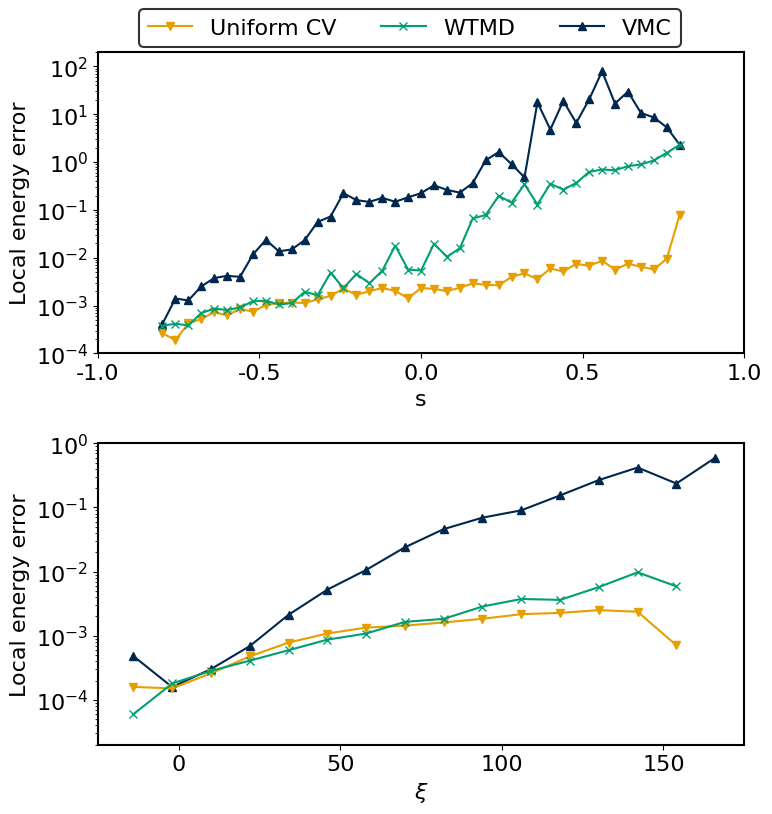

In [6]:
fig,ax=plt.subplots(figsize=[8,8],nrows=2) 
color1,color2,color3="#e69f00","#00274d","#009e73"
  
############################## 
ax[0].set_yscale("log")
ax[1].set_yscale("log")
cvplot=np.array([-1,-0.5,0,0.5,1])
cvticklabels=[str(cv) for cv in cvplot]
ax[0].set_xticks(cvplot)
ax[0].set_xticklabels(cvticklabels)

Splot=np.arange(0,500,50)
Sticklabels=[str(S) for S in Splot]
ax[1].set_xticks(Splot)
ax[1].set_xticklabels(Sticklabels)


# ax[0].set_xlabel("Iteration")
# ax[0].set_ylabel("Energy error")
ax[0].set_ylabel(r"Local energy error")
ax[1].set_ylabel(r"Local energy error")

ax[0].set_xlabel(r"s")
ax[1].set_xlabel(r"$\xi$")
ax[0].set_xlim([-1,1]) 
ax[1].set_xlim([-25,175]) 
ax[0].set_ylim([1e-4,2e2]) 
ax[1].set_ylim([2e-5,1e0]) 
# Create custom legend handles for the line plots
line1_handle = mlines.Line2D([], [], color=color1, marker='v', label='Uniform CV')
line2_handle = mlines.Line2D([], [], color=color3, marker='x', label='WTMD')
line3_handle = mlines.Line2D([], [], color=color2, marker='^', label='VMC')

# Combine the line objects and custom boxplot handle
legend_handles = [line1_handle, line2_handle, line3_handle,]

# Create a single legend
leg=fig.legend(handles=legend_handles,prop={'size': 16},ncol=3,\
               bbox_to_anchor=(0.53,1.00),loc='center')
leg.get_frame().set_linewidth(1.5)
leg.get_frame().set_edgecolor('black')

ax[0].plot(cv_unique, SRHlocerrormean, color=color2,marker="^")
ax[0].plot(cv_unique, vinlaerrormean,color=color1,marker="v")
ax[0].plot(cv_unique, WLerrormean, color=color3,marker="x")
ax[1].plot(xi_unique_plot,xiSRHlocerrormean, color=color2,marker="^" )
ax[1].plot(xi_unique_plot,xivinlaerrormean ,color=color1,marker="v")
ax[1].plot(xi_unique_plot,xiWLerrormean, color=color3 ,marker="x")

fig.tight_layout()
fig.savefig("Fig5_weightedvmc_cv_wtmd_nobox.png",dpi=300, bbox_inches = "tight") 
 
